In [ ]:
SAVE_FOLDER = "UniDir_BIPOLAR_DRUG"
SAVE_DIR = f"saliency_output/{SAVE_FOLDER}"


FOLDER = "DGIDB_BIPOLAR/"
DGIDB_DIRECTORY = "../Gen_Hypergraph/output/" + FOLDER
MSIGDB_DIRECTORY = "../Gen_Hypergraph/output/MSigDB_FULL/"
restart_prob = 0.2  # Restart probability (theta)
num_iterations = 10  # Number of iterationsh

In [ ]:
import numpy as np
import json
from scipy.sparse import load_npz
import os
from tqdm import tqdm
# Open the JSON file and load its content into a dictionary
with open(DGIDB_DIRECTORY + "gene_to_index.json", "r") as file:
    dgidb = json.load(file)
with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    msigdb = json.load(file)

In [ ]:
import numpy as np
# Jump probability for matching genes
w = 1

# Number of genes (assuming they are both of same size or matchable)
num_genes_dgidb = len(dgidb)
num_genes_msigdb = len(msigdb)

# Initialize the inter-layer matrix (D) with zeros
D = np.zeros((num_genes_dgidb, num_genes_msigdb))
i = 0
# Build the inter-layer matrix (D)
for gene_dgidb, idx_dgidb in dgidb.items():
    # If the gene exists in both gene-to-index mappings
    if gene_dgidb in msigdb:      
        idx_msigdb = msigdb[gene_dgidb]
        D[idx_dgidb, idx_msigdb] = w  # Set jump probability
        i += 1
rows_with_high_sum = np.where(D.sum(axis=1) > 0)[0]
# Load matrices
MSIGDB_weighted_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
MSIGDB_binary_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_binary_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_vector =  np.load(DGIDB_CONVERGED_VECTOR_PATH)

num_genes_MSIGDB = MSIGDB_binary_matrix.shape[0]  # Number of genes in MSIGDB
# Initialize probability vectors
v0 = np.zeros(num_genes_MSIGDB)  # Combined vector for DGIDB and MSIGDB
teleport = np.zeros(num_genes_MSIGDB)  # Restart probability vector
# Initialize probability vectors
v0[:] = 1.0 / (num_genes_MSIGDB)  # Starting on DGIDB
teleport[:] = 1.0 / (num_genes_MSIGDB)


In [ ]:
import torch
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert sparse matrices to dense (or use PyTorch sparse support if memory limited)
MSIGDB_weighted = torch.tensor(MSIGDB_weighted_matrix.toarray(), dtype=torch.float32, device=device)
MSIGDB_binary = torch.tensor(MSIGDB_binary_matrix.toarray(), dtype=torch.float32, device=device)
DGIDB_binary = torch.tensor(DGIDB_binary_matrix.toarray(), dtype=torch.float32, device=device)
# DGIDB_vector = torch.tensor(DGIDB_vector, dtype=torch.float32, device=device)
# D = torch.tensor(D, dtype=torch.float32, device=device)

num_genes_MSIGDB = MSIGDB_binary.shape[0]
v0 = torch.full((num_genes_MSIGDB,), 1.0 / num_genes_MSIGDB, dtype=torch.float32, device=device)
teleport = v0.clone()
P = MSIGDB_weighted @ MSIGDB_weighted.T


In [ ]:

def get_hyper_randomwalk_torch(DGIDB_binary_matrix, DGIDB_vector, MSIGDB_weighted_matrix, MSIGDB_binary_matrix, D, restart_prob, num_iterations, P):
    vi = v0.clone()
    distance_list = []
    dgidb_vector_complete = np.zeros(num_genes_MSIGDB)

    for gene in tqdm(range(num_genes_MSIGDB), desc="DGIDB full vector calculation"):
        # Intra-hypergraph transitions in MSIGDB (moving within MSIGDB)
        connected_pathways = MSIGDB_binary_matrix[gene, :].nonzero()[1]  # Nonzero columns in MSIGDB binary matrix

        if len(connected_pathways) == 0:
            continue  # Skip if no pathways are found

        for pathway in connected_pathways:
            # Find genes connected to the selected pathway (weighted transition in MSIGDB)
            connected_genes = MSIGDB_weighted_matrix[:, pathway].toarray().flatten()
            neighbor_genes = np.where(connected_genes > 0)[0]  # Get genes with nonzero weight

            # Check if the current gene has a DGIDB connection
            dgidb_gene = np.where(D[:, gene] > 0)[0]  # Find DGIDB neighbors of the current MSIGDB gene
            if len(dgidb_gene) == 1:
                dgidb_drugs = DGIDB_binary_matrix[dgidb_gene[0], :].nonzero()[1]
                neighbor_genes_set = set()  # To avoid duplicates
            
                for drug in dgidb_drugs:
                    # Get genes connected through the same drug (edge)
                    connected_genes = DGIDB_binary_matrix[:, drug].toarray().flatten()
                    neighbor_genes = np.where(connected_genes > 0)[0]
                    # Add unique neighbors to the set
                    neighbor_genes_set.update(neighbor_genes)

                # Sum contributions from unique DGIDB neighbors
                if len(neighbor_genes_set) > 0:
                    neighbor_genes_list = list(neighbor_genes_set)
                    dgidb_contribution = np.sum(DGIDB_vector[neighbor_genes_list])  # Sum unique contributions
                    dgidb_vector_complete[gene] += dgidb_contribution  # Store in the complete vector

    # Normalize dgidb_vector_complete to avoid overflow
    dgidb_vector_complete /= np.sum(dgidb_vector_complete) if np.sum(dgidb_vector_complete) > 0 else 1
    dgidb_vector_complete = torch.from_numpy(dgidb_vector_complete).to(device)
    for k in range(num_iterations):
        print(f"Iteration {k + 1}")
        vj = vi.clone()

        # Vectorized transition step
        # Resulting shape will be (n, n)

        # Step 2: Normalize P by dividing by the sum of each column (with a small constant to avoid division by zero)
        P = P / (P.sum(dim=0, keepdim=True) + 1e-9)
        vi_new = torch.matmul(P.T.float(), vj.float())  # Transition from vj to vi_new using matrix multiplication

        # Normalize and combine
        vi_new = vi_new / (vi_new.sum() + 1e-9)
        
        vi = restart_prob * vi_new.T + (1 - restart_prob) * teleport + dgidb_vector_complete

        distance = torch.sum(torch.abs(vj - vi)).item()
        distance_list.append(distance)


    importance_scores = torch.argsort(vi, descending=True)
    importance_values = vi[importance_scores]

    return {
        "Importance": list(zip(importance_scores.tolist(), importance_values.tolist())),
        "Distance": distance_list
    }


In [ ]:
import pandas as pd
# Save directory for saliency scores
os.makedirs(SAVE_DIR, exist_ok=True)

# Get baseline (full graph) run
result = get_hyper_randomwalk_torch(DGIDB_binary_matrix, DGIDB_vector, MSIGDB_weighted_matrix, MSIGDB_binary_matrix, D, restart_prob, num_iterations, P)

In [ ]:

# Save baseline
df_baseline = pd.DataFrame(result["Importance"], columns=["GeneIndex", "Score"])
df_baseline.to_csv(os.path.join(SAVE_DIR, "baseline.csv"), index=False)

## Drug Perturbations

In [ ]:
import json
with open("../Methods/id_to_gene_claim.json", "r") as file:
    ncbi = json.load(file)
DGIDB = pd.read_csv("../Data/DGIDB/DrugToGene.tsv", sep="\t")
gene_to_id = {v: k for k, v in ncbi.items()}


In [ ]:
def get_gene_ids_for_drug(drug_name):
    genes = DGIDB[DGIDB['drug_name'] == drug_name]['gene_name'].dropna().unique().tolist()
    gene_ids = [gene_to_id[gene] for gene in genes if gene in gene_to_id]
    return gene_ids
bipolar_drugs = ['CLONAZEPAM', 'BUPROPION', 'SERTRALINE', 'OLANZAPINE', 'ZIPRASIDONE', 'QUETIAPINE', 'CHLORPROMAZINE', 'CARBAMAZEPINE', 'ALLOPURINOL', 'PERPHENAZINE', 'VALPROIC ACID', 'CLOZAPINE', 'LITHIUM', 'RISPERIDONE', 'LAMOTRIGINE', 'ARIPIPRAZOLE']

In [ ]:
VECTOR_DIR = "saliency_output/UniDir_BIPOLAR_DRUG"
os.makedirs(SAVE_DIR, exist_ok=True)


for drug in tqdm(bipolar_drugs, desc="Running saliency analysis"):
    gene_ncbi_ids = get_gene_ids_for_drug(drug)
    if gene_ncbi_ids:
        msigdb_indices = [msigdb[ncbi_id] for ncbi_id in gene_ncbi_ids if ncbi_id in dgidb and ncbi_id in msigdb]
        # Step 4: Create a copy of the matrix
        new_matrix_weighted = MSIGDB_weighted_matrix.copy()

        # Step 5: Zero out the relevant rows
        new_matrix_weighted[msigdb_indices, :] = 0
        # Step 4: Create a copy of the matrix
        new_matrix_binary = MSIGDB_binary_matrix.copy()

        # Step 5: Zero out the relevant rows
        new_matrix_binary[msigdb_indices, :] = 0

        MSIGDB_weighted = torch.tensor(new_matrix_weighted.toarray(), dtype=torch.float32, device=device)
        MSIGDB_binary = torch.tensor(new_matrix_binary.toarray(), dtype=torch.float32, device=device)
        # DGIDB_vector = torch.tensor(DGIDB_vector, dtype=torch.float32, device=device)
        # D = torch.tensor(D, dtype=torch.float32, device=device)

        num_genes_MSIGDB = MSIGDB_binary.shape[0]
        P = MSIGDB_weighted @ MSIGDB_weighted.T
        print(drug)
        result = get_hyper_randomwalk_torch(
            DGIDB_binary_matrix,
            DGIDB_vector,
            new_matrix_binary,
            new_matrix_weighted,
            D,
            restart_prob,
            num_iterations,
            P
        )

        df = pd.DataFrame(result["Importance"], columns=["GeneIndex", "Score"])
        output_path = os.path.join(SAVE_DIR, f"drug_{drug}_saliency.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved to {output_path}")

print("✅ Done generating saliency scores for all DGIDB vectors.")

In [1]:
print("asdadd")

asdadd


In [61]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
with open("../Methods/id_to_gene_claim.json", "r") as file:
    ncbi = json.load(file)
DGIDB = pd.read_csv("../Data/DGIDB/DrugToGene.tsv", sep="\t")
gene_to_id = {v: k for k, v in ncbi.items()}
MSIGDB_DIRECTORY = "../Gen_Hypergraph/output/MSigDB_FULL/"

with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    msigdb = json.load(file)

# Invert it to get: index → NCBI ID
index_to_ncbi = {str(v): k for k, v in msigdb.items()}

def get_gene_ids_for_drug(drug_name):
    genes = DGIDB[DGIDB['drug_name'] == drug_name]['gene_name'].dropna().unique().tolist()
    gene_ids = [gene_to_id[gene] for gene in genes if gene in gene_to_id]
    return gene_ids
# with open(HYPERGRAPH_DIRECTORY + "gene_to_index.json", "r") as file:
#     gene_to_index = json.load(file)
# with open(HYPERGRAPH_DIRECTORY + "drug_to_index.json", "r") as file:
#     drug_to_index = json.load(file)
# Path to folder containing saliency CSVs
SAL_DIR = "saliency_output/UniDir_BIPOLAR_DRUG/"

# Load baseline
baseline_df = pd.read_csv(os.path.join(SAL_DIR, "baseline.csv"))
baseline_scores = baseline_df.set_index("GeneIndex")["Score"]

# Initialize storage
saliency_matrix = []
drug_indices = []

# Regex pattern to extract drug index
pattern = re.compile(r"drug_(.+?)_saliency\.csv")

# List all saliency CSV files except baseline
csv_files = [f for f in os.listdir(SAL_DIR) if pattern.match(f)]
print(csv_files)
for fname in tqdm(sorted(csv_files, key=lambda f: pattern.match(f).group(1))):
    drug_idx = pattern.match(fname).group(1)
    fpath = os.path.join(SAL_DIR, fname)

    perturbed_df = pd.read_csv(fpath)
    perturbed_scores = perturbed_df.set_index("GeneIndex")["Score"]
    perturbed_scores.index = perturbed_scores.index.astype(int)
    baseline_scores.index = baseline_scores.index.astype(int)

    gene_ncbi_ids = get_gene_ids_for_drug(drug_idx)
    gene_indexes = [msigdb[str(g)] for g in gene_ncbi_ids if str(g) in msigdb]

    # gene_indexes = [msigdb[int(g)] for g in gene_ncbi_ids]

    aligned = perturbed_scores.subtract(baseline_scores, fill_value=0)
    aligned.loc[aligned.index.isin(gene_indexes)] = float("nan")
    # Reindex aligned so order matches baseline_scores.index exactly
    aligned = aligned.reindex(baseline_scores.index, fill_value=0)

    saliency_matrix.append(aligned.values)
    drug_indices.append(drug_idx)


# # Create DataFrame: rows = drugs, cols = genes
saliency_df = pd.DataFrame(saliency_matrix, index=drug_indices, columns=baseline_scores.index)
# Now the rows show drug names instead of indices
print(saliency_df.head())

print(saliency_df.loc["CLONAZEPAM", 6975])

['drug_ALLOPURINOL_saliency.csv', 'drug_CARBAMAZEPINE_saliency.csv', 'drug_CHLORPROMAZINE_saliency.csv', 'drug_CLONAZEPAM_saliency.csv', 'drug_CLOZAPINE_saliency.csv', 'drug_LAMOTRIGINE_saliency.csv', 'drug_LITHIUM_saliency.csv', 'drug_OLANZAPINE_saliency.csv', 'drug_PERPHENAZINE_saliency.csv', 'drug_RISPERIDONE_saliency.csv', 'drug_VALPROIC ACID_saliency.csv', 'drug_ZIPRASIDONE_saliency.csv']


 42%|████▏     | 5/12 [00:00<00:00, 45.82it/s]

True
[7003, 6975, 6981, 7034, 7041, 7038, 7009, 5404, 6977, 6993, 7014, 14432, 7023, 7048, 7030, 6998, 6989, 6971, 17399, 11146, 7027, 11133, 1, 4557, 4618]


100%|██████████| 12/12 [00:00<00:00, 43.08it/s]


GeneIndex          17056     17461     17490     4555      5636      13094  \
ALLOPURINOL     0.001984  0.001850  0.001462  0.001134  0.001120  0.001097   
CARBAMAZEPINE   0.004374       NaN  0.003222       NaN  0.002469  0.002418   
CHLORPROMAZINE  0.005881  0.005484       NaN  0.003368       NaN  0.003251   
CLONAZEPAM      0.000765  0.000714  0.000564  0.000437  0.000432  0.000423   
CLOZAPINE            NaN  0.018774  0.014834       NaN       NaN       NaN   

GeneIndex          9127      3023      15885     7417   ...         15828  \
ALLOPURINOL     0.001028  0.001001  0.000932  0.000924  ... -5.102265e-08   
CARBAMAZEPINE        NaN  0.002206  0.002055  0.002037  ... -1.539593e-08   
CHLORPROMAZINE  0.003045       NaN       NaN       NaN  ...  5.875700e-08   
CLONAZEPAM      0.000396  0.000386  0.000360  0.000356  ... -2.072920e-08   
CLOZAPINE            NaN       NaN  0.009458       NaN  ... -1.142871e-07   

GeneIndex              16986         16987         18057         180

In [62]:
# Convert baseline_df to a Series with GeneIndex as index
baseline_series = baseline_df.set_index("GeneIndex")["Score"]

# Now divide saliency_df by this Series (broadcasting by column)
saliency_ratio_df = saliency_df.divide(baseline_series, axis=1)


In [63]:
print(saliency_ratio_df)

GeneIndex          17056     17461     17490     4555      5636      13094  \
ALLOPURINOL     0.086246  0.086217  0.086190  0.085907  0.086074  0.086101   
CARBAMAZEPINE   0.190136       NaN  0.189979       NaN  0.189800  0.189779   
CHLORPROMAZINE  0.255623  0.255577       NaN  0.255011       NaN  0.255149   
CLONAZEPAM      0.033268  0.033259  0.033248  0.033122  0.033201  0.033208   
CLOZAPINE            NaN  0.874965  0.874641       NaN       NaN       NaN   
LAMOTRIGINE     0.068746  0.068718  0.068706  0.068477  0.068613  0.068626   
LITHIUM         0.138632  0.138576  0.138501  0.138477  0.138480  0.138350   
OLANZAPINE      0.331259  0.331156  0.331036       NaN  0.330721  0.330636   
PERPHENAZINE    0.112564  0.112536       NaN  0.112349  0.112389  0.112308   
RISPERIDONE     0.408273       NaN  0.407959       NaN       NaN  0.407571   
VALPROIC ACID   0.266929  0.266844  0.266681       NaN  0.266509  0.266418   
ZIPRASIDONE     0.112288  0.112279  0.112226  0.112116  0.112103

In [64]:
value = saliency_ratio_df.loc["ALLOPURINOL", 7761]
value

0.003269496760248327

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NeurIPS-style font sizes
TITLE_SIZE = 18
LABEL_SIZE = 15
TICK_SIZE = 12
# Melt with 'GeneIndex' as the variable column name
df_long = (
    saliency_ratio_df
    .reset_index()
    .melt(id_vars='index', var_name='GeneIndex', value_name='SaliencyRatio')
    .rename(columns={'index': 'Drug'})
)

# Check columns before proceeding
print(df_long.columns)  # Should print: Index(['Drug', 'GeneIndex', 'SaliencyRatio'], dtype='object')

# Drop NaN and inf
df_long_clean = df_long[
    ~df_long['SaliencyRatio'].isna() & ~np.isinf(df_long['SaliencyRatio'])
]

# Compute absolute value
df_long_clean['AbsVal'] = df_long_clean['SaliencyRatio'].abs()

# Sort and group by Drug, get top 20 per drug
top_perturbations = (
    df_long_clean
    .sort_values(['Drug', 'AbsVal'], ascending=[True, False])
    .groupby('Drug')
    .head(20)
)
print(top_perturbations)

Index(['Drug', 'GeneIndex', 'SaliencyRatio'], dtype='object')


C:\Users\richa\AppData\Local\Temp\ipykernel_21892\239252960.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_clean['AbsVal'] = df_long_clean['SaliencyRatio'].abs()


             Drug GeneIndex  SaliencyRatio    AbsVal
3936  ALLOPURINOL      9198      -0.289607  0.289607
3996  ALLOPURINOL     15071      -0.245573  0.245573
4020  ALLOPURINOL      9590      -0.204953  0.204953
7920  ALLOPURINOL      7977      -0.196588  0.196588
4464  ALLOPURINOL       717      -0.190215  0.190215
...           ...       ...            ...       ...
179   ZIPRASIDONE      5673       0.111994  0.111994
131   ZIPRASIDONE     17513       0.111988  0.111988
191   ZIPRASIDONE     12028       0.111976  0.111976
167   ZIPRASIDONE      4618       0.111973  0.111973
263   ZIPRASIDONE      1192       0.111966  0.111966

[240 rows x 4 columns]


             Drug GeneIndex  SaliencyRatio    AbsVal    NCBI_ID       GeneName
3936  ALLOPURINOL      9198      -0.289607  0.289607     317749        DHRS4L2
3996  ALLOPURINOL     15071      -0.245573  0.245573     574537         UGT2A2
4020  ALLOPURINOL      9590      -0.204953  0.204953     341392          ACSM4
7920  ALLOPURINOL      7977      -0.196588  0.196588        278          AMY1C
4464  ALLOPURINOL       717      -0.190215  0.190215  100526830  SLX1A-SULT1A3
...           ...       ...            ...       ...        ...            ...
179   ZIPRASIDONE      5673       0.111994  0.111994       2194           FASN
131   ZIPRASIDONE     17513       0.111988  0.111988        718             C3
191   ZIPRASIDONE     12028       0.111976  0.111976       4781           NFIB
167   ZIPRASIDONE      4618       0.111973  0.111973       1576         CYP3A4
263   ZIPRASIDONE      1192       0.111966  0.111966      10213         PSMD14

[240 rows x 6 columns]


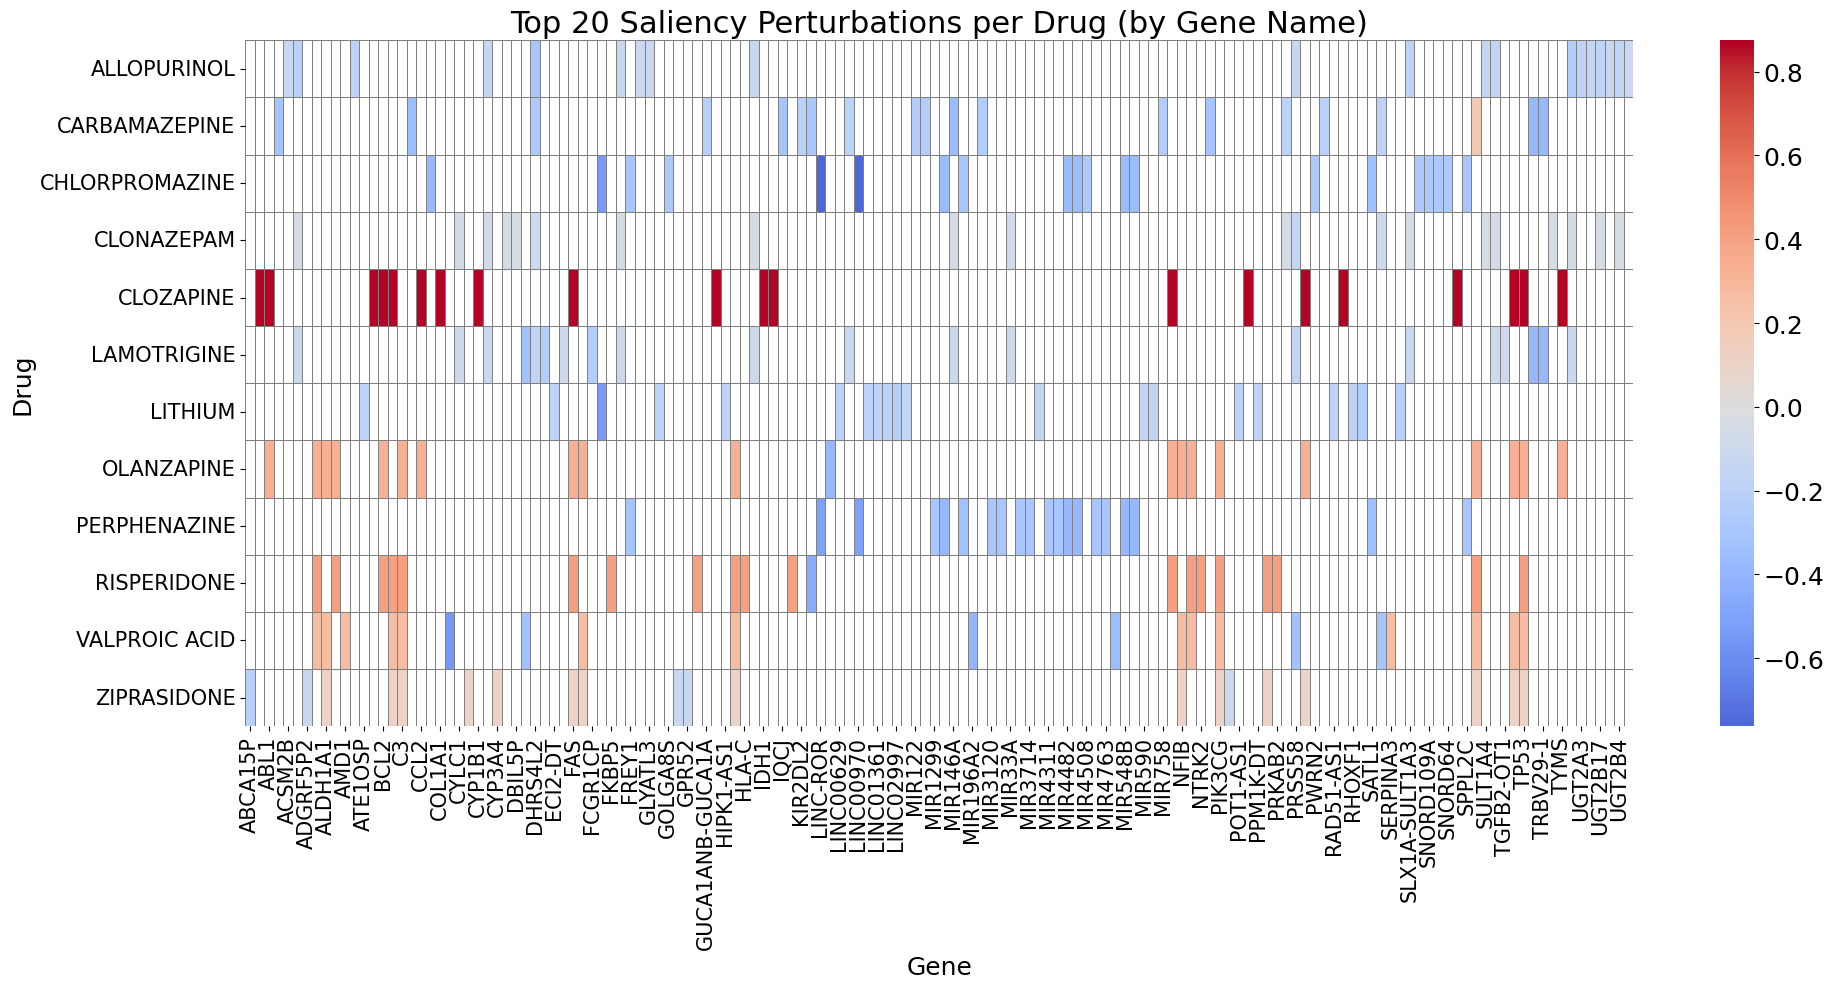

In [67]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Load mapping
with open("../Methods/id_to_gene_claim.json", "r") as file:
    ncbi = json.load(file)
MSIGDB_DIRECTORY = "../Gen_Hypergraph/output/MSigDB_FULL/"

with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    msigdb = json.load(file)

# Invert it to get: index → NCBI ID
index_to_ncbi = {str(v): k for k, v in msigdb.items()}
top_perturbations['NCBI_ID'] = top_perturbations['GeneIndex'].map(lambda x: index_to_ncbi.get(str(x), f"Unknown_{x}"))
# Map GeneIndex (which is likely a string or int) to gene claim names
top_perturbations['GeneName'] = top_perturbations['NCBI_ID'].map(lambda x: ncbi.get(str(x), f"Gene_{x}"))
print(top_perturbations)
top_perturbations.to_csv("TOP.csv")
# Pivot with gene names instead of IDs
heatmap_data = top_perturbations.pivot(index='Drug', columns='GeneName', values='SaliencyRatio')

# Define NeurIPS-style font sizes
TITLE_SIZE = 22
LABEL_SIZE = 18
TICK_SIZE = 15

# Plot heatmap
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Top 20 Saliency Perturbations per Drug (by Gene Name)', fontsize=TITLE_SIZE)
plt.xlabel('Gene', fontsize=LABEL_SIZE)
plt.ylabel('Drug', fontsize=LABEL_SIZE)

plt.xticks(rotation=90, fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)

# Adjust colorbar tick label size
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=LABEL_SIZE)

plt.tight_layout()
plt.show()
